# 🧠 Sentiment Analysis on Amazon Reviews (PySpark + PyTorch)

Mục tiêu: 
- Làm sạch dữ liệu đánh giá sản phẩm bằng PySpark.
- Chuyển đổi dữ liệu đã xử lý sang tensor để huấn luyện mô hình PyTorch.

Công cụ:
- PySpark (xử lý dữ liệu lớn)
- PyTorch (huấn luyện mô hình Deep Learning)


## Khám phá dữ liệu (Exploratory Data Analysis - EDA)

Trong phần này, chúng ta sẽ:
- Đọc dữ liệu gốc từ file `.csv`
- Kiểm tra schema, số lượng dòng/cột
- Kiểm tra dữ liệu thiếu (null/missing)
- Chuẩn hoá cột `Rating`
- Phân tích phân bố điểm đánh giá và cảm xúc
- Tính toán độ dài review
- Phân tích theo thời gian (nếu có cột ngày đánh giá)


### Import thư viện

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

### Tạo Spark Session

In [2]:
# ==============================================================
# 🔹 Tạo SparkSession
# ==============================================================

spark = SparkSession.builder \
    .appName("Amazon_Review_Sentiment") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/17 15:43:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/17 15:43:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Đọc dữ liệu gốc

In [3]:
# ==============================================================
# 🔹 Đọc dữ liệu gốc
# ==============================================================

data_path = "../data/raw/Amazon_Reviews.csv"

df = spark.read.option("header", True).option("inferSchema", True).csv(data_path)

print("Đọc dữ liệu thành công.")
df.show(5, truncate=False)


Đọc dữ liệu thành công.
+----------------+-------------------------------+-------+------------+------------------------+----------------------+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------+
|Reviewer Name   |Profile Link                   |Country|Review Count|Review Date             |Rating                |Review Title                                   |Review Tex

### Thông tin tổng quan về dữ liệu

In [4]:
# ==============================================================
# 🔹 Thông tin tổng quan
# ==============================================================

print("Schema:")
df.printSchema()

print(f"Tổng số dòng: {df.count():,}")
print(f"Tổng số cột: {len(df.columns)}")
print("Danh sách cột:", df.columns)


Schema:
root
 |-- Reviewer Name: string (nullable = true)
 |-- Profile Link: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Review Count: string (nullable = true)
 |-- Review Date: string (nullable = true)
 |-- Rating: string (nullable = true)
 |-- Review Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Date of Experience: string (nullable = true)

Tổng số dòng: 21,656
Tổng số cột: 9
Danh sách cột: ['Reviewer Name', 'Profile Link', 'Country', 'Review Count', 'Review Date', 'Rating', 'Review Title', 'Review Text', 'Date of Experience']


### Kiểm tra giá trị thiếu

In [5]:
# ==============================================================
# 🔹 Kiểm tra giá trị thiếu
# ==============================================================

null_df = df.select([
    F.count(F.when(F.col(c).isNull() | (F.col(c) == ''), c)).alias(c)
    for c in df.columns
])
print("Số lượng giá trị null hoặc rỗng trong từng cột:")
null_df.show(vertical=True)

Số lượng giá trị null hoặc rỗng trong từng cột:
-RECORD 0-----------------
 Reviewer Name      | 0   
 Profile Link       | 141 
 Country            | 436 
 Review Count       | 523 
 Review Date        | 565 
 Rating             | 581 
 Review Title       | 590 
 Review Text        | 595 
 Date of Experience | 920 



### Thống kê cột Rating

In [6]:
# ==============================================================
# 🔹 Thống kê cột Rating
# ==============================================================

df = df.withColumn(
    "Rating",
    F.regexp_extract(F.col("Rating"), r"(\d)(?=\s*out of 5)", 1).cast(IntegerType())
)

# Thống kê điểm đánh giá
rating_stats = df.groupBy("Rating").agg(
    F.count("*").alias("count")
).orderBy("Rating")

print("\n Thống kê điểm Rating:")
rating_stats.show()


 Thống kê điểm Rating:
+------+-----+
|Rating|count|
+------+-----+
|  NULL|  601|
|     1|13123|
|     2| 1227|
|     3|  885|
|     4| 1292|
|     5| 4528|
+------+-----+



### Thống kê độ dài review

In [7]:
# ==============================================================
# 🔹 Thống kê độ dài nội dung Review
# ==============================================================

if "Review Text" in df.columns:
    df = df.withColumn("ReviewLength", F.length(F.col("Review Text")))

    review_stats = df.select(
        F.mean("ReviewLength").alias("mean_len"),
        F.min("ReviewLength").alias("min_len"),
        F.max("ReviewLength").alias("max_len")
    ).collect()[0]

    print(f"Độ dài trung bình: {review_stats['mean_len']:.2f}")
    print(f"Ngắn nhất: {review_stats['min_len']}, Dài nhất: {review_stats['max_len']}")


Độ dài trung bình: 422.60
Ngắn nhất: 6, Dài nhất: 8166


### Phân tích theo thời gian

In [8]:
# ==============================================================
# 🔹 Phân tích theo thời gian (nếu có cột Review Date)
# ==============================================================

if "Review Date" in df.columns:
    df = df.withColumn("Review Date", F.to_date(F.col("Review Date")))
    time_dist = df.groupBy(F.year("Review Date").alias("year")).count().orderBy("year")
    print("Số lượng review theo năm:")
    time_dist.show()

Số lượng review theo năm:
+----+-----+
|year|count|
+----+-----+
|NULL|  601|
|2007|    1|
|2008|    3|
|2009|    9|
|2010|   22|
|2011|  360|
|2012| 1166|
|2013|   88|
|2014|  166|
|2015|  175|
|2016|  317|
|2017|  616|
|2018| 1041|
|2019| 2314|
|2020| 2638|
|2021| 2750|
|2022| 2551|
|2023| 4017|
|2024| 2821|
+----+-----+



## Tiền xử lý dữ liệu (Data Preprocessing)

Trong phần này, chúng ta sẽ:
- Chuẩn hoá cột **Rating** về giá trị số (1–5)
- Gán nhãn **Sentiment** (`positive`, `negative`)
- Làm sạch văn bản: xoá ký tự đặc biệt, chữ thường, loại bỏ stopwords
- Kết hợp tiêu đề + nội dung review
- Lưu dữ liệu đã chuẩn hoá ra file `.parquet` để phục vụ huấn luyện mô hình.


### Chuẩn hoá cột Rating

In [9]:
# ==============================================================
# 🔹 Chuẩn hoá cột Rating
# ==============================================================
df = df.withColumn(
    "Rating",
    F.regexp_extract(F.col("Rating"), r"(\d+)", 1).cast(IntegerType())
)

df = df.filter((F.col("Rating") >= 1) & (F.col("Rating") <= 5))
print("Đã chuẩn hoá cột Rating về khoảng [1–5].")

df.select("Rating").distinct().orderBy("Rating").show()

Đã chuẩn hoá cột Rating về khoảng [1–5].
+------+
|Rating|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+



### Gán nhãn Sentiment

In [10]:
# ==============================================================
# 🔹 Gán nhãn cảm xúc dựa trên Rating
# ==============================================================

df = df.withColumn(
    "Sentiment",
    F.when(F.col("Rating") <= 2, "negative")
     .otherwise("positive")
)

df.groupBy("Sentiment").count().show()


+---------+-----+
|Sentiment|count|
+---------+-----+
| positive| 6705|
| negative|14350|
+---------+-----+



### Làm sạch văn bản

In [11]:
# ==============================================================
# 🔹 Làm sạch nội dung Review
# ==============================================================

if "Review Title" in df.columns and "Review Text" in df.columns:
    df = df.withColumn("FullReview", F.concat_ws(". ", "Review Title", "Review Text"))
elif "Review Text" in df.columns:
    df = df.withColumnRenamed("Review Text", "FullReview")

df = (
    df.withColumn("FullReview", F.lower("FullReview"))
      .withColumn("FullReview", F.regexp_replace("FullReview", r"[^a-zA-Z0-9\s]", " "))
      .withColumn("FullReview", F.regexp_replace("FullReview", r"\s+", " "))
      .filter(F.length("FullReview") > 10)
)

print("Đã làm sạch văn bản.")
df.select("FullReview").show(5, truncate=False)


Đã làm sạch văn bản.
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|FullReview                                                                                                                                                                                                                                                                                                                                              

### Loại bỏ Stopwords

In [12]:
# ==============================================================
# 🔹 Tokenization & Stopword Removal
# ==============================================================

tokenizer = Tokenizer(inputCol="FullReview", outputCol="Words")
remover = StopWordsRemover(inputCol="Words", outputCol="FilteredWords")

df = tokenizer.transform(df)
df = remover.transform(df)
df = df.withColumn("CleanText", F.concat_ws(" ", "FilteredWords"))
df = df.filter(F.length("CleanText") > 10)

df.select("CleanText").show(5, truncate=False)
print("Đã loại bỏ stopwords.")


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CleanText                                                                                                                                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Loại bỏ dữ liệu trùng lặp

In [13]:
# ==============================================================
# Loại bỏ dữ liệu trùng lặp
# ==============================================================

before_count = df.count()
df = df.dropDuplicates(["CleanText"])
after_count = df.count()

print(f"Đã loại bỏ {before_count - after_count} dòng trùng lặp.")
print(f"Còn lại {after_count} dòng dữ liệu sau khi làm sạch & unique.")
df.select("CleanText").show(5, truncate=False)

Đã loại bỏ 81 dòng trùng lặp.
Còn lại 20967 dòng dữ liệu sau khi làm sạch & unique.


+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|CleanText                                                                                                                                                                                                                                                                                                                                                              |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Giữ cột quan trọng và lưu dữ liệu

In [14]:
# ==============================================================
# 🔹 Giữ cột cần thiết và lưu dữ liệu
# ==============================================================

keep_cols = ["Reviewer Name", "Country", "Review Date", "Rating", "CleanText", "Sentiment"]
df = df.select([c for c in keep_cols if c in df.columns])

print("Dữ liệu đã được xử lý và tinh gọn:")
df.show(5, truncate=False)

output_path = "../data/processed"
df.write.mode("overwrite").parquet(output_path)
print(f"Đã lưu dữ liệu tiền xử lý tại: {output_path}")


Dữ liệu đã được xử lý và tinh gọn:


+-------------+-------+-----------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|Reviewer Name|Country|Review Date|Rating|CleanText                                                                                                                                                                                                                                  

Đã lưu dữ liệu tiền xử lý tại: ../data/processed


### Data Validation sau khi preprocessing

In [15]:
# ==============================================================
# 🔹 Data Validation sau khi preprocessing
# ==============================================================

from pyspark.sql import functions as F

# Kiểm tra null
print("Kiểm tra null:")
df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

# Kiểm tra trùng lặp
dup_count = df.groupBy("CleanText").count().filter(F.col("count") > 1).count()
print(f"Số dòng trùng lặp: {dup_count}")

# Kiểm tra phân bố rating
df.groupBy("Rating").count().orderBy("Rating").show()

print("Validation hoàn tất – dữ liệu đã sẵn sàng cho feature engineering.")


Kiểm tra null:


-RECORD 0------------
 Reviewer Name | 0   
 Country       | 0   
 Review Date   | 0   
 Rating        | 0   
 CleanText     | 0   
 Sentiment     | 0   



Số dòng trùng lặp: 0


+------+-----+
|Rating|count|
+------+-----+
|     1|13105|
|     2| 1225|
|     3|  879|
|     4| 1274|
|     5| 4484|
+------+-----+

Validation hoàn tất – dữ liệu đã sẵn sàng cho feature engineering.


## Xây dựng mô hình Machine Learning

### Import thư viện

In [16]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

### Đọc dữ liệu và trích xuất đặc trưng

In [17]:
df = spark.read.parquet("../data/processed/")

# Chuyển sang pandas để train model sklearn
pandas_df = df.select("CleanText", "Sentiment").toPandas()
pandas_df = pandas_df.dropna()

print("Dữ liệu sẵn sàng để train:", pandas_df.shape)
pandas_df.head()

Dữ liệu sẵn sàng để train: (20967, 2)


,CleanText,Sentiment
0,0 win complaint 0 win complaint amazon right ...,negative
1,100 shipping didn tell 100 shipping didn tell...,negative
2,10000000000 stars bad company 10000000000 sta...,negative
3,514 billion revenues least come good customer...,negative
4,600 order missing ve lot amazon orders incorr...,negative


### Chuẩn bị dữ liệu cho mô hình

In [18]:
X = pandas_df["CleanText"]
y = pandas_df["Sentiment"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# TF-IDF vectorization
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape:", X_train_tfidf.shape)

TF-IDF shape: (16773, 5000)


### Định nghĩa 3 mô hình và tham số để Cross Validation

In [19]:
models = {
    "logistic_regression": {
        "model": LogisticRegression(max_iter=200),
        "params": {"C": [0.1, 1, 5]}
    },
    "svm": {
        "model": LinearSVC(),
        "params": {"C": [0.1, 1, 5]}
    },
    "random_forest": {
        "model": RandomForestClassifier(),
        "params": {"n_estimators": [100, 200], "max_depth": [10, 20]}
    }
}

### Train và Cross Validation cho từng mô hình

In [20]:
best_models = {}

for name, cfg in models.items():
    print(f"\n Training {name} ...")
    
    grid = GridSearchCV(
        estimator=cfg["model"],
        param_grid=cfg["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    
    grid.fit(X_train_tfidf, y_train)
    
    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    
    print(f" {name} accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Lưu model tốt nhất
    joblib.dump(best_model, f"../models/ml/{name}_model.pkl")
    best_models[name] = (best_model, acc)


 Training logistic_regression ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
 logistic_regression accuracy: 0.9266
              precision    recall  f1-score   support

    negative       0.93      0.97      0.95      2866
    positive       0.93      0.83      0.88      1328

    accuracy                           0.93      4194
   macro avg       0.93      0.90      0.91      4194
weighted avg       0.93      0.93      0.93      4194


 Training svm ...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
 svm accuracy: 0.9220
              precision    recall  f1-score   support

    negative       0.91      0.98      0.94      2866
    positive       0.95      0.80      0.87      1328

    accuracy                           0.92      4194
   macro avg       0.93      0.89      0.91      4194
weighted avg       0.92      0.92      0.92      4194


 Training random_forest ...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
 random_forest accuracy

In [21]:
best_name = max(best_models, key=lambda x: best_models[x][1])
print(f"\nMô hình tốt nhất: {best_name} (Accuracy = {best_models[best_name][1]:.4f})")


Mô hình tốt nhất: logistic_regression (Accuracy = 0.9266)


## Xây dựng mô hình Deep Learning

### Import thư viện

In [22]:
# ==============================================================
# Import thư viện
# ==============================================================

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np

print("PyTorch version:", torch.__version__)


2025-10-17 15:44:17.930687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-17 15:44:17.975668: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-17 15:44:19.079461: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


PyTorch version: 2.8.0+cu128


### Đọc dữ liệu từ Spark output

In [23]:
# ==============================================================
# Đọc dữ liệu từ Spark output
# ==============================================================

df = spark.read.parquet("../data/processed/")

# Chuyển sang pandas để huấn luyện với PyTorch
pandas_df = df.select("CleanText", "Sentiment").toPandas()
pandas_df = pandas_df.dropna()

print("Dữ liệu sẵn sàng để train:", pandas_df.shape)
pandas_df.head()

Dữ liệu sẵn sàng để train: (20967, 2)


,CleanText,Sentiment
0,0 win complaint 0 win complaint amazon right ...,negative
1,100 shipping didn tell 100 shipping didn tell...,negative
2,10000000000 stars bad company 10000000000 sta...,negative
3,514 billion revenues least come good customer...,negative
4,600 order missing ve lot amazon orders incorr...,negative


### Tokenize & Encode dữ liệu

In [24]:
# ==============================================================
# Tokenize & Encode dữ liệu
# ==============================================================

MAX_VOCAB = 10000
MAX_LEN = 100

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(pandas_df["CleanText"])

X = tokenizer.texts_to_sequences(pandas_df["CleanText"])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post', truncating='post')

encoder = LabelEncoder()
y = encoder.fit_transform(pandas_df["Sentiment"])

# Chia train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Tạo Dataset và DataLoader

In [25]:
# ==============================================================
# Tạo Dataset và DataLoader
# ==============================================================

class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = ReviewDataset(X_train, y_train)
test_ds = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


### Mô hình LSTM cơ bản

In [26]:
# ==============================================================
# Mô hình LSTM cơ bản
# ==============================================================

class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.dropout(h_n[-1])
        return self.fc(out)

### Mô hình BiLSTM

In [27]:
# ==============================================================
# Mô hình BiLSTM
# ==============================================================

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=3, dropout=0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.bilstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
    
    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.bilstm(x)
        h = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)  # concat hướng forward & backward
        out = self.dropout(h)
        return self.fc(out)


### Hàm train chung cho LSTM & BiLSTM

In [28]:
# ==============================================================
# Hàm train chung cho LSTM & BiLSTM
# ==============================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, test_loader, num_epochs=5, lr=1e-3):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Đánh giá
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                correct += (preds == y_batch).sum().item()
                total += y_batch.size(0)
        acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.3f}, Test Acc: {acc:.4f}")


### Train LSTM và BiLSTM

In [29]:
# ==============================================================
# Train LSTM và BiLSTM
# ==============================================================

vocab_size = min(MAX_VOCAB, len(tokenizer.word_index) + 1)
num_classes = len(encoder.classes_)

print("🔹 Training LSTM...")
lstm_model = LSTMClassifier(vocab_size, num_classes=num_classes)
train_model(lstm_model, train_loader, test_loader, num_epochs=5)

print("\n🔹 Training BiLSTM...")
bilstm_model = BiLSTMClassifier(vocab_size, num_classes=num_classes)
train_model(bilstm_model, train_loader, test_loader, num_epochs=5)


🔹 Training LSTM...
Epoch 1/5, Loss: 160.770, Test Acc: 0.6834
Epoch 2/5, Loss: 97.911, Test Acc: 0.8691
Epoch 3/5, Loss: 71.610, Test Acc: 0.8755
Epoch 4/5, Loss: 66.416, Test Acc: 0.8937
Epoch 5/5, Loss: 66.352, Test Acc: 0.8958

🔹 Training BiLSTM...
Epoch 1/5, Loss: 97.438, Test Acc: 0.8820
Epoch 2/5, Loss: 59.203, Test Acc: 0.9115
Epoch 3/5, Loss: 44.411, Test Acc: 0.9161
Epoch 4/5, Loss: 34.644, Test Acc: 0.9187
Epoch 5/5, Loss: 25.561, Test Acc: 0.9125


### Lưu trọng số mô hình

In [ ]:
# ==============================================================
# Lưu trọng số mô hình
# ==============================================================

torch.save(lstm_model.state_dict(), "../models/dl/lstm_model.pt")
torch.save(bilstm_model.state_dict(), "../models/dl/bilstm_model.pt")

print("Đã lưu mô hình LSTM và BiLSTM vào thư mục models/dl/")


Đã lưu mô hình LSTM và BiLSTM vào thư mục models/


### Đánh giá chi tiết

              precision    recall  f1-score   support

    negative       0.92      0.93      0.92      2866
    positive       0.85      0.82      0.83      1328

    accuracy                           0.90      4194
   macro avg       0.88      0.88      0.88      4194
weighted avg       0.90      0.90      0.90      4194



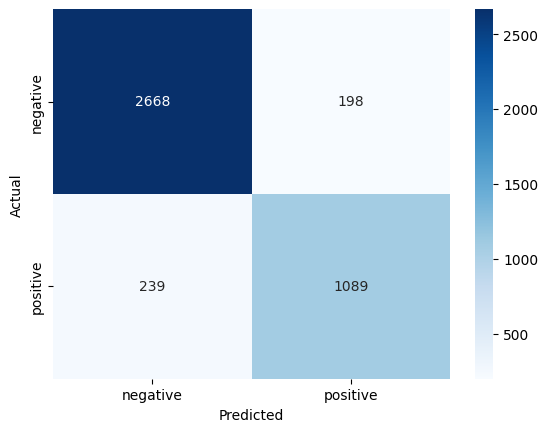

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            labels.extend(y_batch.numpy())

    print(classification_report(labels, preds, target_names=encoder.classes_))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=encoder.classes_,
                yticklabels=encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model(lstm_model, test_loader)